In [98]:
# Import packages
import os
import numpy as np
import tensorflow as tf

from tensorflow_vgg import vgg16
from tensorflow_vgg import utils

In [99]:
# Load target labels
data_dir = '/Users/edwzhang/Documents/Machine Learning/deep-learning/transfer-learning/menwomen/'
contents = os.listdir(data_dir)
classes = [each for each in contents if os.path.isdir(data_dir + each)]
print(classes)

['men', 'women']


In [100]:
labels = []
batch = []
codes = None
batch_size = 5
with tf.Session() as sess:
    # Create VGG16 object
    if 'vgg' in globals():
        print('vgg object already exists.  Will not create again.')
    else:
        input_ = tf.placeholder(tf.float32, [None, 224, 224, 3])
        vgg = vgg16.Vgg16()
        vgg.build(input_)
    
    for each in classes:
        print("Starting {} images".format(each))
        class_path = data_dir + each
        files = os.listdir(class_path)
        for ii, file in enumerate(files):
            img = utils.load_image(os.path.join(class_path, file))
            batch.append(img.reshape((1, 224, 224, 3)))
            labels.append(each)
            #print("File {} processed".format(file))
            
            # Load a batch of 5 images into VGG16 DNN and take the output of the first FC layer
            if ii % batch_size ==0 or ii == len(files)-1:
                images = np.concatenate(batch)
                feed_dict = {input_: images}
                codes_batch = sess.run(vgg.relu6, feed_dict=feed_dict)
        
                if codes is None:
                    codes = codes_batch
                else:
                    codes = np.concatenate((codes, codes_batch))
            
                batch = []
    print("All images processed")
    

"vgg" object already exists.  Will not create again.
Starting men images
Starting women images
All images processed


In [101]:
# One hot encoder of target labels; LabelBinarizer is mostly used for multi-variable one vs all scenario
from sklearn.preprocessing import LabelBinarizer

lb = LabelBinarizer()
lb.fit(labels)

labels_vecs = lb.transform(labels)
labels_vecs = np.hstack((labels_vecs, 1 - labels_vecs))
print labels_vecs[:3]

[[0 1]
 [0 1]
 [0 1]]


In [124]:
# Shuffle and split into training and validation data set
from sklearn.model_selection import StratifiedShuffleSplit

ss = StratifiedShuffleSplit(n_splits=1, test_size=0.2)
train_idx, val_idx = next(ss.split(codes, labels_vecs))

train_x, train_y = codes[train_idx], labels_vecs[train_idx]
val_x, val_y = codes[val_idx], labels_vecs[val_idx]

In [103]:
# Define a new 2 FC layer network
inputs_ = tf.placeholder(tf.float32, shape=[None, codes.shape[1]])
labels_ = tf.placeholder(tf.int64, shape=[None, labels_vecs.shape[1]])

fc = tf.contrib.layers.fully_connected(inputs_, 256)
    
logits = tf.contrib.layers.fully_connected(fc, labels_vecs.shape[1], activation_fn=None)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=labels_, logits=logits)
cost = tf.reduce_mean(cross_entropy)

optimizer = tf.train.AdamOptimizer().minimize(cost)

predicted = tf.nn.softmax(logits)
correct_pred = tf.equal(tf.argmax(predicted, 1), tf.argmax(labels_, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

In [104]:
# Define a function to return training data generators with 10 iterations
def get_batches(x, y, n_batches=10):
    """ Return a generator that yields batches from arrays x and y. """
    batch_size = len(x)//n_batches
    
    for ii in range(0, n_batches*batch_size, batch_size):
        # If we're not on the last batch, grab data with size batch_size
        if ii != (n_batches-1)*batch_size:
            X, Y = x[ii: ii+batch_size], y[ii: ii+batch_size] 
        # On the last batch, grab the rest of the data
        else:
            X, Y = x[ii:], y[ii:]
        # return generators
        yield X, Y

In [125]:
# Train the new 2 FC layer network with 5 epochs and save the weights to a file for future use
epochs = 5
iteration = 0
saver = tf.train.Saver()
with tf.Session() as sess:
    
    sess.run(tf.global_variables_initializer())
    for e in range(epochs):
        for x, y in get_batches(train_x, train_y):
            feed = {inputs_: x,
                    labels_: y}
            loss, _ = sess.run([cost, optimizer], feed_dict=feed)
            print("Epoch: {}/{}".format(e+1, epochs),
                  "Iteration: {}".format(iteration),
                  "Training loss: {:.5f}".format(loss))
            iteration += 1
            
            if iteration % 5 == 0:
                feed = {inputs_: val_x,
                        labels_: val_y}
                val_acc = sess.run(accuracy, feed_dict=feed)
                print("Epoch: {}/{}".format(e+1, epochs),
                      "Iteration: {}".format(iteration),
                      "Validation Acc: {:.4f}".format(val_acc))
    saver.save(sess, "checkpoints/menwomen.ckpt")

('Epoch: 1/5', 'Iteration: 0', 'Training loss: 1.49604')
('Epoch: 1/5', 'Iteration: 1', 'Training loss: 3.76077')
('Epoch: 1/5', 'Iteration: 2', 'Training loss: 4.65451')
('Epoch: 1/5', 'Iteration: 3', 'Training loss: 0.19737')
('Epoch: 1/5', 'Iteration: 4', 'Training loss: 1.59545')
('Epoch: 1/5', 'Iteration: 5', 'Validation Acc: 0.5833')
('Epoch: 1/5', 'Iteration: 5', 'Training loss: 7.84560')
('Epoch: 1/5', 'Iteration: 6', 'Training loss: 1.15581')
('Epoch: 1/5', 'Iteration: 7', 'Training loss: 0.00272')
('Epoch: 1/5', 'Iteration: 8', 'Training loss: 3.10800')
('Epoch: 1/5', 'Iteration: 9', 'Training loss: 8.76913')
('Epoch: 1/5', 'Iteration: 10', 'Validation Acc: 0.8333')
('Epoch: 2/5', 'Iteration: 10', 'Training loss: 0.00000')
('Epoch: 2/5', 'Iteration: 11', 'Training loss: 0.00000')
('Epoch: 2/5', 'Iteration: 12', 'Training loss: 2.32036')
('Epoch: 2/5', 'Iteration: 13', 'Training loss: 1.83560')
('Epoch: 2/5', 'Iteration: 14', 'Training loss: 0.00000')
('Epoch: 2/5', 'Iteration

In [122]:
%matplotlib inline
import matplotlib.pyplot as plt

def predict_manwoman(img_path):
    #img_path = 'flower_photos/JasonRidge.jpeg'
    with tf.Session() as sess:
        img = utils.load_image(img_path)
        img = img.reshape((1, 224, 224, 3))
        plt.imshow(np.squeeze(img))

        feed_dict = {input_: img}
        code = sess.run(vgg.relu6, feed_dict=feed_dict)
        
    saver = tf.train.Saver()
    with tf.Session() as sess:
        saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
        feed = {inputs_: code}
        prediction = sess.run(predicted, feed_dict=feed).squeeze()
    if prediction[1] > prediction[0]:
        return 'man with probability '+ str(prediction[1])
    else:
        return 'woman with probability '+ str(prediction[0])

INFO:tensorflow:Restoring parameters from checkpoints/menwomen.ckpt


'men with probability 1.0'

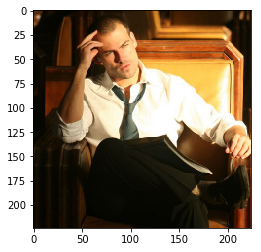

In [109]:
predict_manwoman('flower_photos/JasonRidge.jpeg')

INFO:tensorflow:Restoring parameters from checkpoints/menwomen.ckpt


'women with probability 1.0'

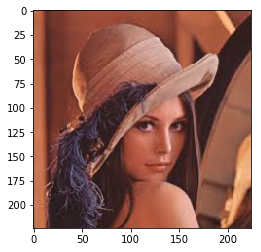

In [111]:
predict_manwoman('flower_photos/lena.jpeg')

INFO:tensorflow:Restoring parameters from checkpoints/menwomen.ckpt


'woman with probability 1.0'

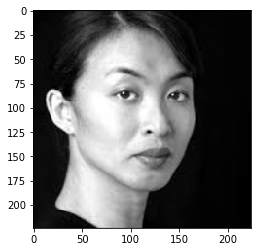

In [164]:
predict_manwoman('flower_photos/jinxing.jpeg')

INFO:tensorflow:Restoring parameters from checkpoints/menwomen.ckpt


'woman with probability 1.0'

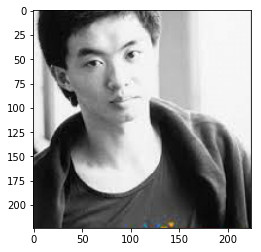

In [165]:
predict_manwoman('flower_photos/jinxing2.jpeg')

INFO:tensorflow:Restoring parameters from checkpoints/menwomen.ckpt


'man with probability 0.999878'

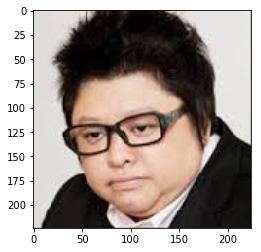

In [163]:
predict_manwoman('flower_photos/hanhong.jpeg')

INFO:tensorflow:Restoring parameters from checkpoints/menwomen.ckpt


'man with probability 1.0'

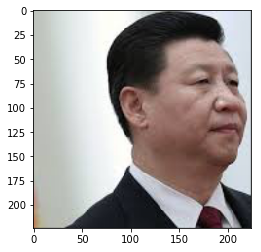

In [166]:
predict_manwoman('flower_photos/jinping.jpeg')

INFO:tensorflow:Restoring parameters from checkpoints/menwomen.ckpt


'woman with probability 1.0'

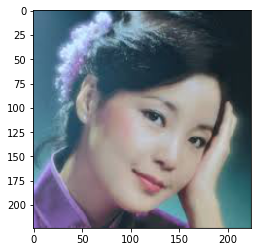

In [167]:
predict_manwoman('flower_photos/lijun.jpeg')

INFO:tensorflow:Restoring parameters from checkpoints/menwomen.ckpt


'woman with probability 1.0'

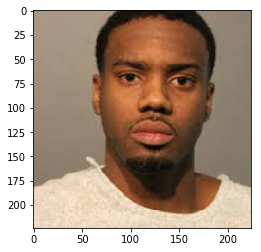

In [171]:
predict_manwoman('flower_photos/man4.jpeg')

In [158]:
# Print Convolution layers dimensions and plot Images after the first layer Convolution and Pooling
vgg16_weight_dict = np.load('tensorflow_vgg/vgg16.npy', encoding='latin1').item()
img_path = 'flower_photos/lena.jpeg'

with tf.Session() as sess:
    img = utils.load_image(img_path)
    img = img.reshape((1,224,224,3))
    
    feed_dict = {input_:img}
    conv1_1_filter = vgg16_weight_dict['conv1_1'][0]
    conv1_1 = sess.run(vgg.conv1_1, feed_dict=feed_dict)
    conv1_2_filter = vgg16_weight_dict['conv1_2'][0]
    conv1_2 = sess.run(vgg.conv1_2, feed_dict=feed_dict)
    pool1 = sess.run(vgg.pool1, feed_dict=feed_dict)
    pool2 = sess.run(vgg.pool2, feed_dict=feed_dict)
    pool3 = sess.run(vgg.pool3, feed_dict=feed_dict)
    pool4 = sess.run(vgg.pool4, feed_dict=feed_dict)
    pool5 = sess.run(vgg.pool5, feed_dict=feed_dict)


    
    print ('Conv 1_1 shape:'+str(conv1_1_filter.shape))
    print ('Image after Conv 1_1:'+str(conv1_1.shape))
    
    print ('Conv 1_2 shape:'+str(conv1_2_filter.shape))
    print ('Image after Conv 1_2'+str(conv1_2.shape))
    
    print ('Image after Pool 1:'+str(pool1.shape))
    print ('Image after Pool 2:'+str(pool2.shape))
    print ('Image after Pool 3:'+str(pool3.shape))
    print ('Image after Pool 4:'+str(pool4.shape))
    print ('Image after Pool 5:'+str(pool5.shape))
  

Conv 1_1 shape:(3, 3, 3, 64)
Image after Conv 1_1:(1, 224, 224, 64)
Conv 1_2 shape:(3, 3, 64, 64)
Image after Conv 1_2(1, 224, 224, 64)
Image after Pool 1:(1, 112, 112, 64)
Image after Pool 2:(1, 56, 56, 128)
Image after Pool 3:(1, 28, 28, 256)
Image after Pool 4:(1, 14, 14, 512)
Image after Pool 5:(1, 7, 7, 512)


In [157]:
import matplotlib.gridspec as gridspec

def plot_conv_images(pooledImages,nrow,ncol):
    fig = plt.figure(figsize=(ncol+1, nrow+1)) 

    gs = gridspec.GridSpec(nrow, ncol,
         wspace=0.0, hspace=0.0, 
         top=1.-0.5/(nrow+1), bottom=0.5/(nrow+1), 
         left=0.5/(ncol+1), right=1-0.5/(ncol+1)) 

    for i in range(nrow):
        for j in range(ncol):
            im = np.squeeze(pooledImages)[:,:,i*nrow+j]
            ax= plt.subplot(gs[i,j])
            ax.imshow(im)
            ax.set_xticklabels([])
            ax.set_yticklabels([])

    plt.show()

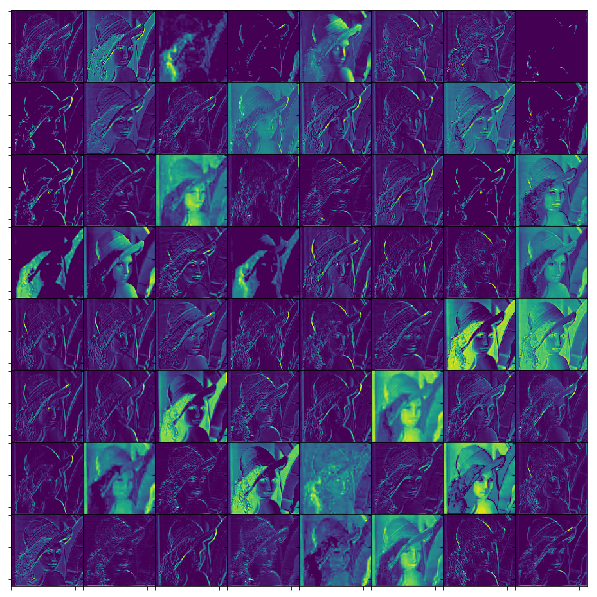

In [161]:
plot_conv_images(pool1,8,8)

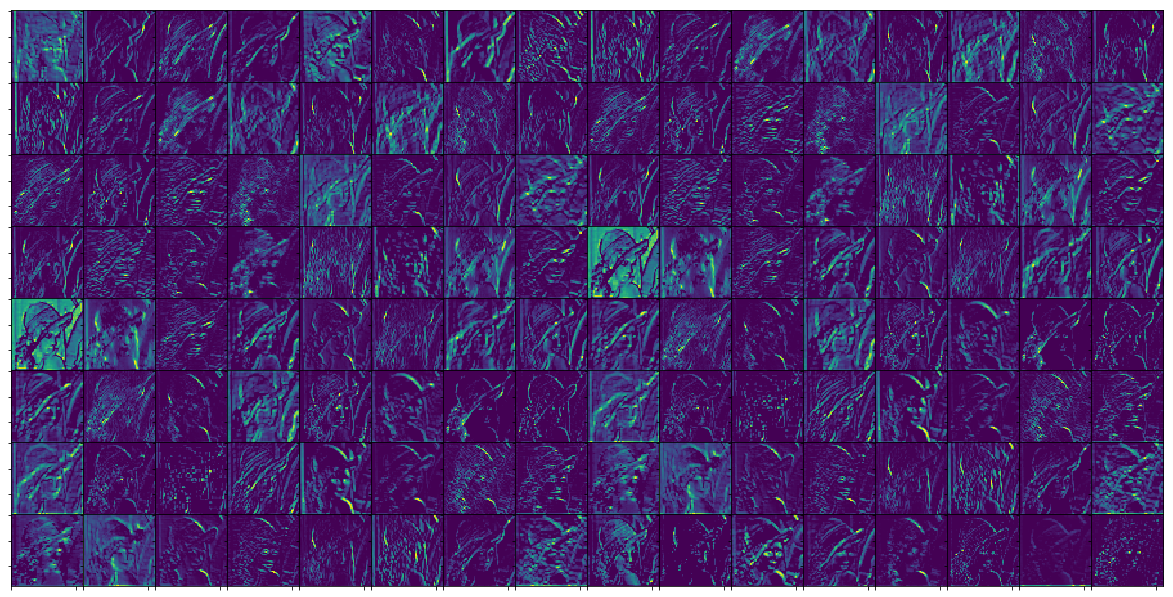

In [159]:
plot_conv_images(pool2,8,16)

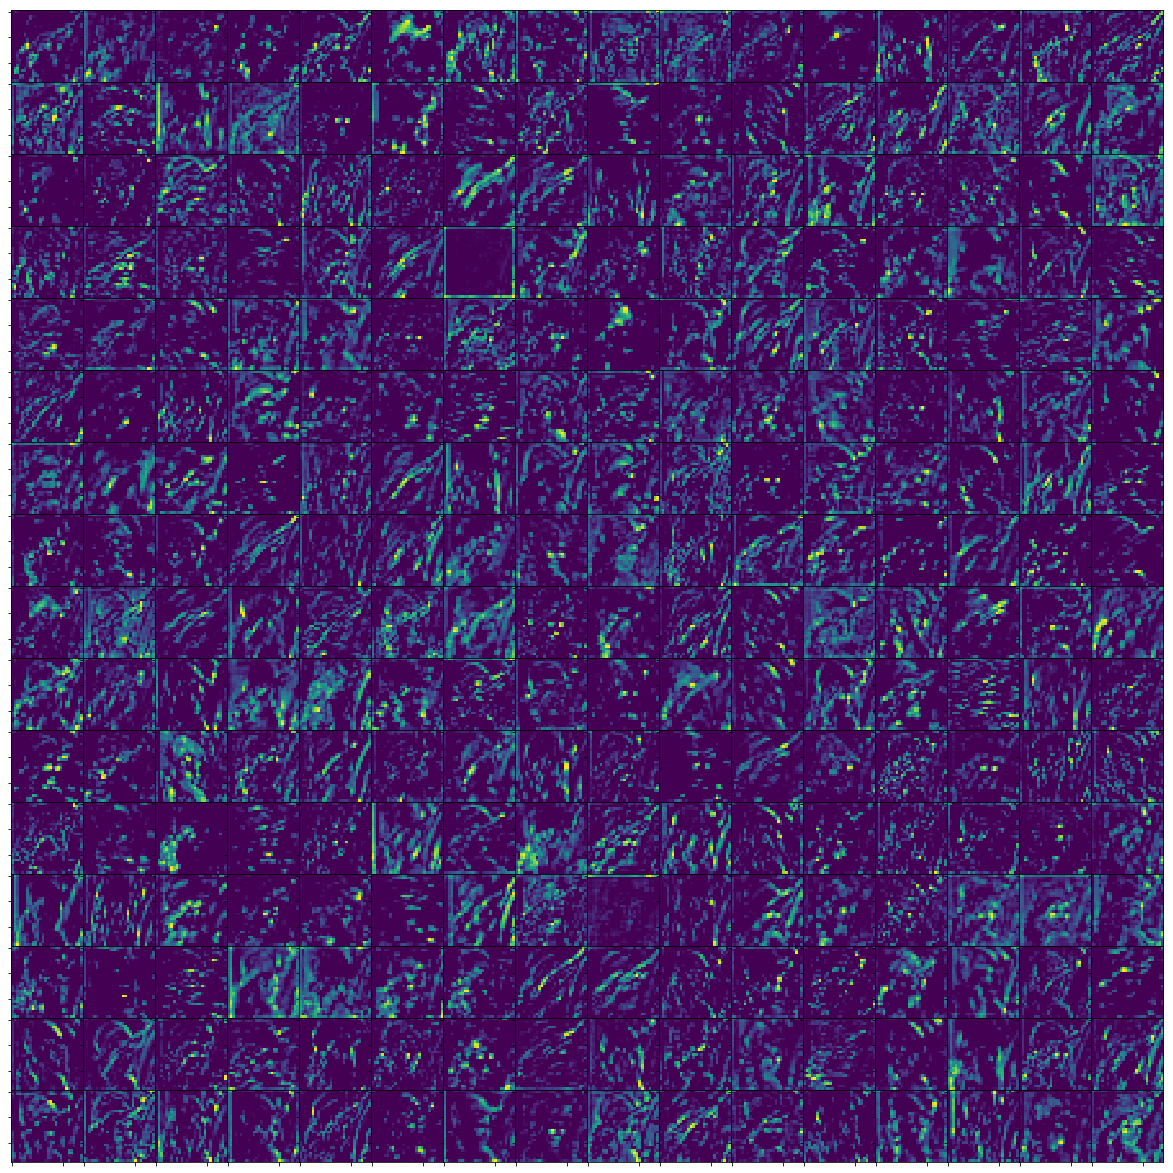

In [160]:
plot_conv_images(pool3,16,16)

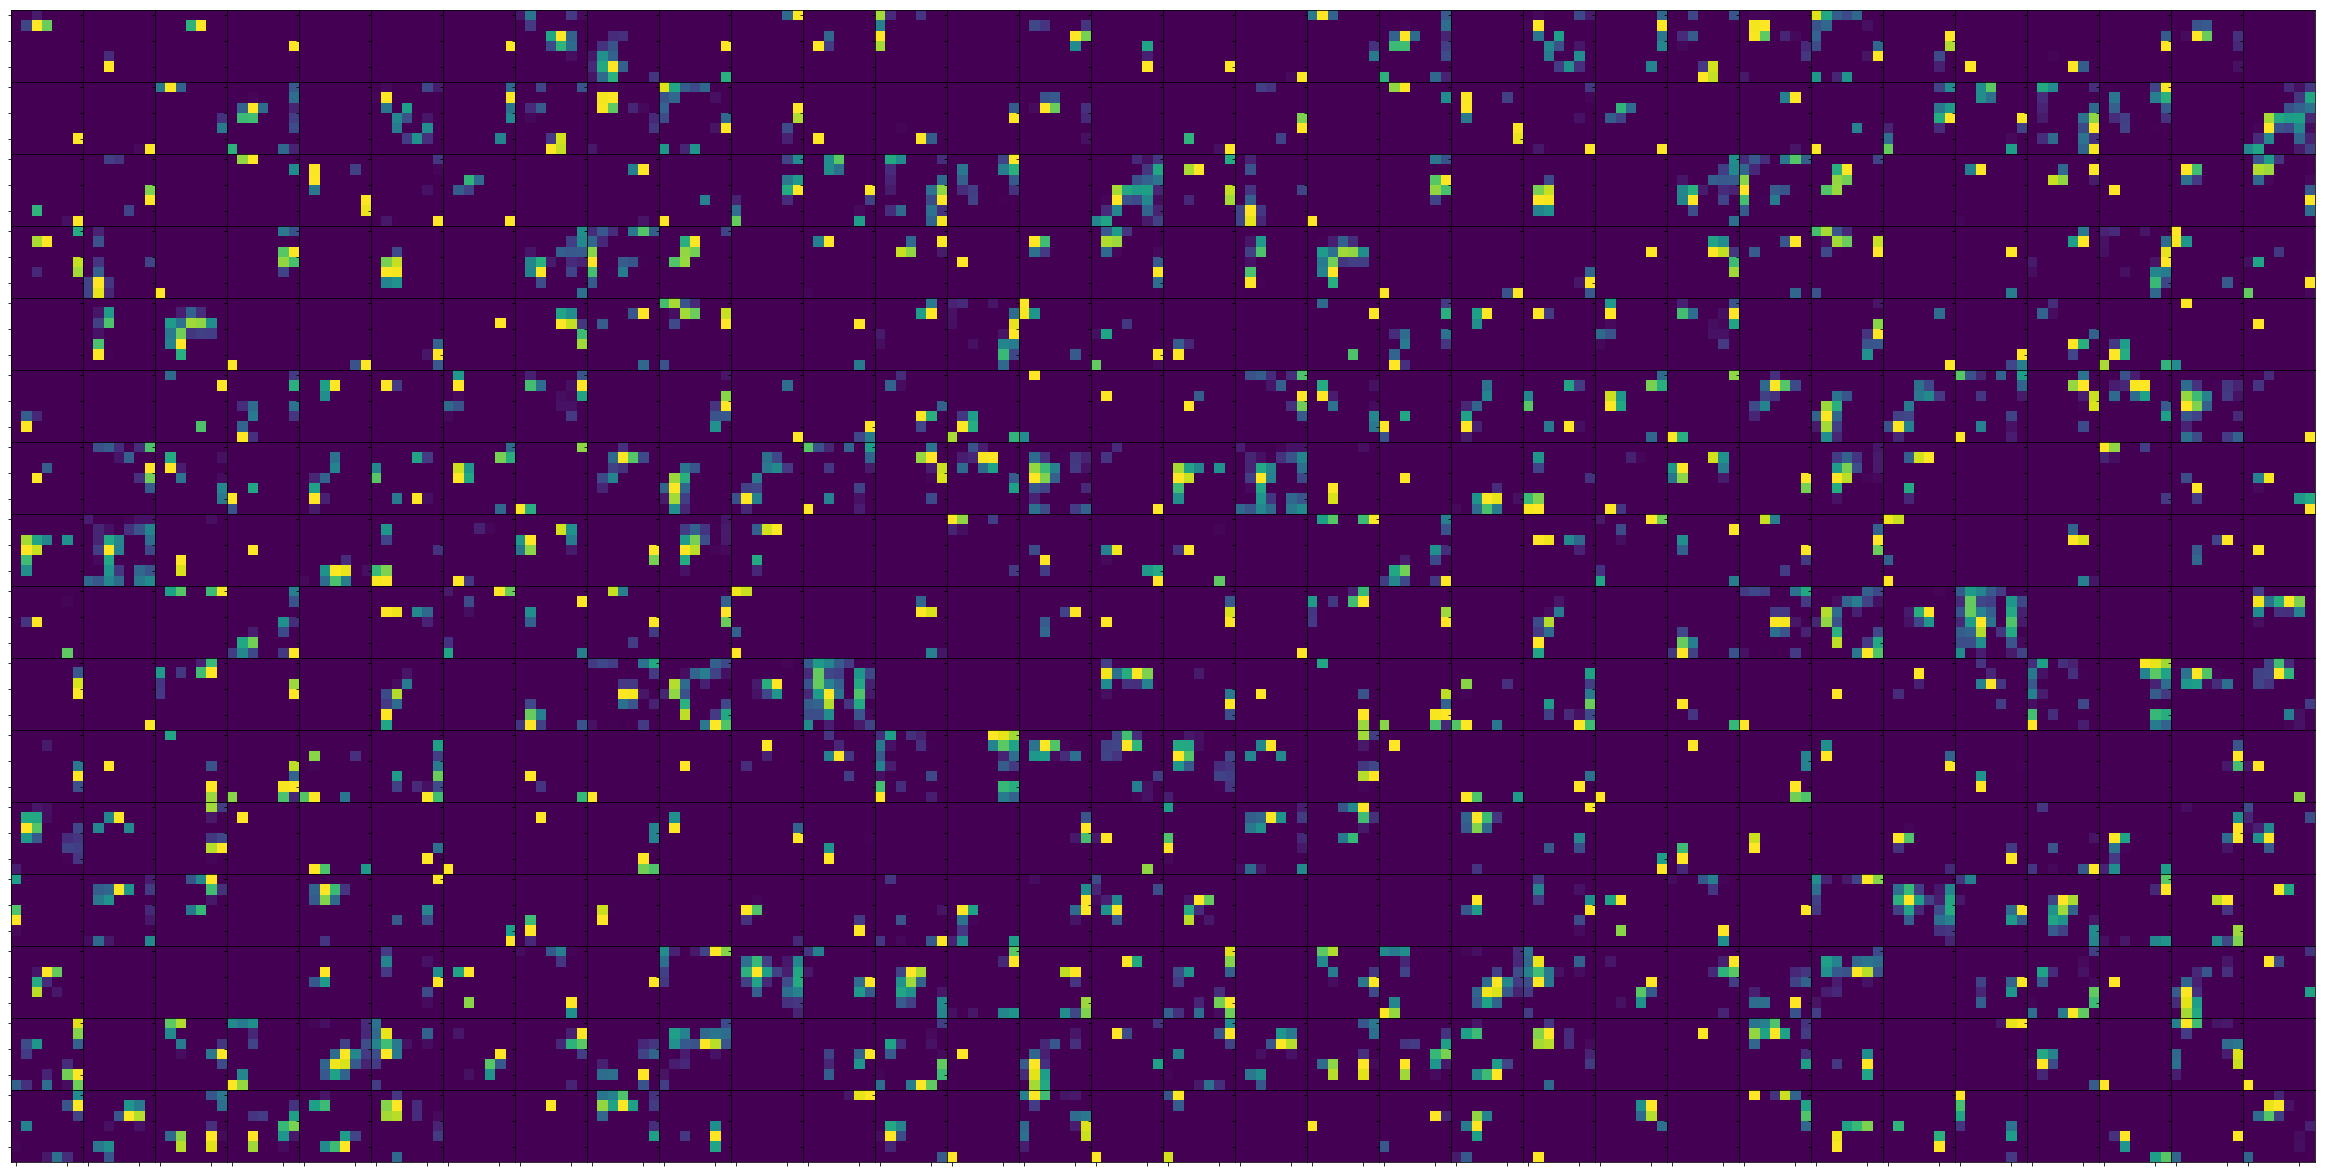

In [162]:
plot_conv_images(pool5,16,32)